# **Section 1 :** Environment setup and data loading

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("<app_name>").getOrCreate())

In [ ]:
df = spark.read.csv('ipl_ball_by_ball.csv',inferSchema="true",header=True)
df1 = spark.read.csv('ipl_matches.csv',inferSchema="true",header=True)
df2 = spark.read.csv('ipl_venue.csv',inferSchema="true",header=True)

In [ ]:
df.createOrReplaceTempView("balls")

df1.createOrReplaceTempView("matches")

df2.createOrReplaceTempView("venue")

In [ ]:
df.show()
df.printSchema()

+--------+------+-----+----+-------------+-------------+------------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|match_id|inning|overs|ball|      batsman|  non_striker|      bowler|batsman_runs|extra_runs|total_runs|non_boundary|is_wicket|dismissal_kind|player_dismissed|fielder|extras_type|        batting_team|        bowling_team|
+--------+------+-----+----+-------------+-------------+------------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|  419157|     2|   16|   4|      V Kohli|R Vinay Kumar|CRD Fernando|           0|         0|         0|           0|        0|            NA|              NA|     NA|         NA|Royal Challengers...|      Mumbai Indians|
|  419157|     2|   16|   5|      V Kohli|R Vinay Kumar|CRD Fernando|           1|         0|         1|        

In [ ]:
df1.show()
df1.printSchema()

+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|match_id|      date|player_of_match|venue_id|neutral_venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|eliminator|method|    umpire1|       umpire2|
+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|  335982|2008-04-18|    BB McCullum|      35|            0|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knight Ri...|   runs|          140|         N|    NA|  Asad Rauf|   RE Koertzen|
|  335983|2008-04-19|     MEK Hussey|      31|            0|     Kings XI Punjab| Chennai Super 

In [ ]:
df2.show()
df2.printSchema()

+--------+--------------------+--------------+
|venue_id|               venue|          city|
+--------+--------------------+--------------+
|       1|Dr. Y.S. Rajasekh...| Visakhapatnam|
|       2|Sharjah Cricket S...|       Sharjah|
|       3|JSCA Internationa...|        Ranchi|
|       4|Saurashtra Cricke...|        Rajkot|
|       5|Shaheed Veer Nara...|        Raipur|
|       6|Maharashtra Crick...|          Pune|
|       7|Subrata Roy Sahar...|          Pune|
|       8|    St George's Park|Port Elizabeth|
|       9|Vidarbha Cricket ...|        Nagpur|
|      12|   Brabourne Stadium|        Mumbai|
|      13|Dr DY Patil Sport...|        Mumbai|
|      14|    Wankhede Stadium|        Mumbai|
|      15|        Eden Gardens|       Kolkata|
|      16|       Nehru Stadium|         Kochi|
|      17|De Beers Diamond ...|     Kimberley|
|      18|          Green Park|        Kanpur|
|      19|New Wanderers Sta...|  Johannesburg|
|      20|Sawai Mansingh St...|        Jaipur|
|      21|Hol

# **Section 2 :** Using pySpark for data analysis

In [ ]:
#1. Find the top 3 venues which hosted the most number of eliminator matches?

spark.sql(
"""
select b.venue,count(b.venue_id) as num_matches from matches a
inner join venue b on a.venue_id=b.venue_id
where a.eliminator = 'Y'
group by b.venue
order by 2 desc;
""").show(3)

+--------------------+-----------+
|               venue|num_matches|
+--------------------+-----------+
|Dubai Internation...|          3|
|Sheikh Zayed Stadium|          2|
|    Feroz Shah Kotla|          1|
+--------------------+-----------+
only showing top 3 rows



In [ ]:
#2. Return most number of catches taken by a player in IPL history?


spark.sql(
"""
select fielder,count(dismissal_kind) as number_of_catches
from balls
where dismissal_kind = 'caught'
group by fielder
order by count(dismissal_kind) desc
"""
).show(1)

+---------+-----------------+
|  fielder|number_of_catches|
+---------+-----------------+
|RG Sharma|               18|
+---------+-----------------+
only showing top 1 row



In [ ]:
#3. Write a query to return a report for highest wicket taker in matches which were affected by Duckworth-Lewis’s method (D/L method).


spark.sql(
"""
select a.bowler,count(a.is_wicket) as number_of_wickets
from balls a, matches b
where a.match_id = b.match_id and b.method == 'D/L' and a.is_wicket = 1
group by bowler
order by number_of_wickets desc
"""
).show()

+---------------+-----------------+
|         bowler|number_of_wickets|
+---------------+-----------------+
|        B Kumar|                3|
|NM Coulter-Nile|                3|
|       UT Yadav|                3|
|       JR Hopes|                2|
|       RR Powar|                2|
|       M Morkel|                2|
|     GD McGrath|                1|
|     AD Russell|                1|
|       A Mishra|                1|
|   MC Henriques|                1|
|     PJ Sangwan|                1|
|      PP Chawla|                1|
|        P Kumar|                1|
|      RS Bopara|                1|
|       TA Boult|                1|
|      CJ Jordan|                1|
+---------------+-----------------+



In [ ]:
#4. Write a query to return a report for highest strike rate by a batsman in non powerplay overs(7-20 overs)
#Note: strike rate = (Total Runs scored/Total balls faced by player) *100, Make sure that balls faced by players should be legal delivery (not wide balls or no balls).


spark.sql(
"""
select batsman, (sum(batsman_runs)/count(batsman))*100 as strike_rate
from balls
where overs between 7 and 20
group by batsman
order by strike_rate desc
"""
).show()

+---------------+------------------+
|        batsman|       strike_rate|
+---------------+------------------+
|      SM Curran|             300.0|
|       Umar Gul|             300.0|
|   Kamran Akmal|             300.0|
|  ST Jayasuriya|241.17647058823528|
|     AUK Pathan|             240.0|
|        MS Gony|216.66666666666666|
|       M Morkel| 209.0909090909091|
|    RA Tripathi|205.55555555555554|
|        I Udana|             200.0|
|     D Salunkhe|             200.0|
|     JC Buttler|194.44444444444443|
|      JC Archer|190.47619047619045|
|       DR Smith| 189.0909090909091|
|       DJ Hooda| 185.1851851851852|
|        HM Amla|             180.0|
|      SR Watson|179.06976744186048|
|Joginder Sharma|177.77777777777777|
|     PJ Cummins|             175.0|
|        SS Iyer|173.37278106508876|
|        PP Shaw|173.33333333333334|
+---------------+------------------+
only showing top 20 rows



In [ ]:
#5. Write a query to return a report for highest extra runs in a venue (stadium, city).

spark.sql(
"""
select c.venue,c.city, sum(a.extra_runs) as total_extra_runs
from balls a
join matches b on a.match_id = b.match_id
join venue c on b.venue_id = c.venue_id
group by c.venue,c.city
order by total_extra_runs desc
"""
).show()

+--------------------+-------------+----------------+
|               venue|         city|total_extra_runs|
+--------------------+-------------+----------------+
|    Feroz Shah Kotla|        Delhi|             183|
|M.Chinnaswamy Sta...|    Bengaluru|             160|
|    Wankhede Stadium|       Mumbai|             133|
|Dr DY Patil Sport...|       Mumbai|             100|
|MA Chidambaram St...|      Chennai|              99|
|        Eden Gardens|      Kolkata|              91|
|Sawai Mansingh St...|       Jaipur|              84|
|Rajiv Gandhi Inte...|    Hyderabad|              82|
|Dubai Internation...|        Dubai|              79|
|Sheikh Zayed Stadium|    Abu Dhabi|              70|
|Punjab Cricket As...|   Chandigarh|              46|
|Sardar Patel Stad...|    Ahmedabad|              31|
|Dr. Y.S. Rajasekh...|Visakhapatnam|              30|
|       Nehru Stadium|        Kochi|              24|
|          Green Park|       Kanpur|              24|
|Punjab Cricket As...|   Cha

In [ ]:
#6. Write a query to return a report for the cricketers with the most number of players of the match award in neutral venues.

spark.sql(
"""
select b.player_of_match,count(b.player_of_match) as Number_of_player_of_match
from matches b, venue c 
where b.neutral_venue = 1 and c.venue_id = b.venue_id
group by b.player_of_match
order by Number_of_player_of_match desc
"""
).show()

+----------------+-------------------------+
| player_of_match|Number_of_player_of_match|
+----------------+-------------------------+
|       JP Duminy|                        3|
|      GJ Maxwell|                        3|
|       JH Kallis|                        3|
|       YK Pathan|                        3|
|  Sandeep Sharma|                        2|
|    Yuvraj Singh|                        2|
|       ML Hayden|                        2|
|    SR Tendulkar|                        2|
|     LRPL Taylor|                        2|
|       MK Pandey|                        2|
|  AB de Villiers|                        2|
|        SK Raina|                        2|
|DPMD Jayawardene|                        2|
|   KC Sangakkara|                        2|
|       RG Sharma|                        2|
|  M Muralitharan|                        2|
|        DR Smith|                        2|
|    AC Gilchrist|                        2|
|     S Badrinath|                        1|
|        V

In [ ]:
#7. Write a query to get a list of top 10 players with the highest batting average Note: Batting average is the total number of runs 
#scored divided by the number of times they have been out (Make sure to include run outs (on non-striker end) as valid out 
#while calculating average).
spark.sql(
"""
select batsman, (sum(batsman_runs)/sum(is_wicket)) as batting_average
from balls
group by batsman
order by batting_average desc
"""
).show()

+---------------+------------------+
|        batsman|   batting_average|
+---------------+------------------+
|  ST Jayasuriya|             131.0|
|        HM Amla|              92.0|
|    SA Asnodkar|              69.0|
|      SS Tiwary| 65.33333333333333|
|Y Venugopal Rao|62.333333333333336|
|      V Shankar|              61.5|
|      SR Watson|              57.5|
|   F du Plessis|              56.5|
|       SA Yadav|              56.0|
|     MEK Hussey|              55.0|
|      R Tewatia|              52.5|
|       SE Marsh|              52.5|
|       KL Rahul|50.285714285714285|
|       DJ Hooda|              50.0|
|      AM Rahane| 48.44444444444444|
|     S Anirudha|              47.0|
|      DJ Hussey|             46.25|
|       MS Dhoni|42.857142857142854|
|      DA Warner| 41.76923076923077|
|    S Badrinath| 41.57142857142857|
+---------------+------------------+
only showing top 20 rows



In [ ]:
#8. Write a query to find out who has officiated (as an umpire) the most number of matches in IPL.


spark.sql(
"""
select umpire1, count(umpire1) as num_times_officiated
from matches
group by umpire1
order by num_times_officiated desc
limit 1
"""
).show()

+---------------+--------------------+
|        umpire1|num_times_officiated|
+---------------+--------------------+
|HDPK Dharmasena|                  78|
+---------------+--------------------+



In [ ]:
#9. Find venue details of the match where V Kohli scored his highest individual runs in IPL.

spark.sql(
"""
select b.match_id,first(c.venue),first(c.city),sum(a.batsman_runs)
from balls a
join matches b on a.match_id=b.match_id
join venue c on b.venue_id =c.venue_id
where a.batsman= 'V Kohli'
group by b.match_id
order by sum(a.batsman_runs) desc limit 1; 
""").show()

+--------+--------------------+-----------+-----------------+
|match_id|        first(venue)|first(city)|sum(batsman_runs)|
+--------+--------------------+-----------+-----------------+
| 1216514|Sheikh Zayed Stadium|  Abu Dhabi|               72|
+--------+--------------------+-----------+-----------------+

+---------------------+
|Winner_when_toss_lost|
+---------------------+
|                  398|
+---------------------+



In [ ]:
#10. Creative Case study:
#Please analyze how winning/losing tosses can impact a match and it's result? (Marks for Visualization also)
spark.sql(
"""
select 'Won when toss won' as Win_status,count(winner) as Winner
from matches
where winner = toss_winner

UNION 

select 'Won when toss lost' as Win_status,count(winner) as Winner
from matches
where winner <> toss_winner
"""
).show()

+------------------+------+
|        Win_status|Winner|
+------------------+------+
| Won when toss won|   418|
|Won when toss lost|   398|
+------------------+------+



In [ ]:
(418/(418+398))*100

51.225490196078425

We can see the number of winning matches when the toss is won is 418 whereas, the number of matches won when the toss is lost is 398 so, the toss winners have a 51.23%(approximately) chance of winning the match which is not so significant when compared to the matches won when the toss is lost.

In [ ]:
data = spark.sql(
"""
select 'Won when toss won' as Win_status,count(winner) as Winner
from matches
where winner = toss_winner

UNION 

select 'Won when toss lost' as Win_status,count(winner) as Winner
from matches
where winner <> toss_winner
"""
)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

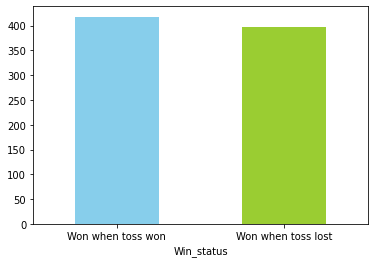

In [ ]:
import matplotlib.pyplot as plt
data.toPandas().plot(x = "Win_status", y = "Winner", kind = "bar", legend=False, color=['skyblue', 'yellowgreen'])
plt.xticks(rotation=0)

# **Section 3 :** Expose Data

In [1]:
from Database import database

In [2]:
db = database.Database()

In [4]:
db.get_status()

'Database connected'

In [3]:
db.get_query1_result()

('Dubai International Cricket Stadium', 3)
('Sheikh Zayed Stadium', 2)
('Feroz Shah Kotla', 1)
('M.Chinnaswamy Stadium', 1)
('MA Chidambaram Stadium, Chepauk', 1)
('Newlands', 1)
('Rajiv Gandhi International Stadium, Uppal', 1)
('Sardar Patel Stadium, Motera', 1)
('Saurashtra Cricket Association Stadium', 1)
('Wankhede Stadium', 1)


In [5]:
db.get_query2_result()

('KD Karthik', 118)
('MS Dhoni', 113)
('AB de Villiers', 103)
('SK Raina', 99)
('RG Sharma', 88)
('RV Uthappa', 87)
('KA Pollard', 84)
('V Kohli', 76)
('S Dhawan', 73)
('MK Pandey', 70)
('PA Patel', 69)
('DA Warner', 66)
('NV Ojha', 65)
('DJ Bravo', 64)
('RA Jadeja', 63)
('WP Saha', 62)
('AM Rahane', 58)
('AT Rayudu', 56)
('F du Plessis', 54)
('SV Samson', 52)
('AC Gilchrist', 51)
('DA Miller', 49)
('Q de Kock', 49)
('HH Pandya', 48)
('SA Yadav', 48)
('M Vijay', 47)
('MK Tiwary', 46)
('RR Pant', 46)
('KC Sangakkara', 45)
('SPD Smith', 44)
('DR Smith', 41)
('YK Pathan', 41)
('KL Rahul', 39)
('SR Watson', 38)
('BB McCullum', 37)
('Harbhajan Singh', 37)
('AR Patel', 36)
('Mandeep Singh', 36)
('MA Agarwal', 35)
('PP Chawla', 34)
('V Sehwag', 34)
('CH Morris', 32)
('DPMD Jayawardene', 32)
('JC Buttler', 31)
('R Vinay Kumar', 31)
('GJ Maxwell', 30)
('JH Kallis', 30)
('R Ashwin', 30)
('UT Yadav', 29)
('Yuvraj Singh', 29)
('G Gambhir', 28)
('IK Pathan', 28)
('JP Duminy', 28)
('KM Jadhav', 28)


In [6]:
db.get_query3_result()

('AB Dinda', 8)
('R Ashwin', 8)
('MC Henriques', 7)
('B Kumar', 6)
('DL Vettori', 5)
('JD Unadkat', 5)
('L Balaji', 5)
('TA Boult', 5)
('A Mishra', 4)
('M Ntini', 4)
('PP Chawla', 4)
('YS Chahal', 4)
('A Zampa', 3)
('NLTC Perera', 3)
('NM Coulter-Nile', 3)
('S Aravind', 3)
('S Nadeem', 3)
('UT Yadav', 3)
('AD Russell', 2)
('AJ Tye', 2)
('B Laughlin', 2)
('BB Sran', 2)
('CK Langeveldt', 2)
('D Wiese', 2)
('DW Steyn', 2)
('Iqbal Abdulla', 2)
('JH Kallis', 2)
('JR Hopes', 2)
('M Morkel', 2)
('MR Marsh', 2)
('Mujeeb Ur Rahman', 2)
('P Kumar', 2)
('RR Powar', 2)
('SC Ganguly', 2)
('SP Narine', 2)
('SR Watson', 2)
('A Nehra', 1)
('AM Salvi', 1)
('AR Patel', 1)
('AS Rajpoot', 1)
('B Lee', 1)
('CH Morris', 1)
('CJ Jordan', 1)
('DE Bollinger', 1)
('DS Kulkarni', 1)
('GD McGrath', 1)
('GJ Maxwell', 1)
('I Sharma', 1)
('IK Pathan', 1)
('JA Morkel', 1)
('JC Archer', 1)
('K Gowtham', 1)
('KJ Abbott', 1)
('LR Shukla', 1)
('MA Starc', 1)
('Mohammed Shami', 1)
('PJ Sangwan', 1)
('R Shukla', 1)
('RP Si

In [7]:
db.get_query4_result()

('AC Blizzard', 200)
('B Stanlake', 200)
('ER Dwivedi', 200)
('Kamran Akmal', 200)
('RS Sodhi', 200)
('Umar Gul', 200)
('A Ashish Reddy', 100)
('A Choudhary', 100)
('A Flintoff', 100)
('A Mithun', 100)
('A Nortje', 100)
('A Symonds', 100)
('AA Chavan', 100)
('AA Jhunjhunwala', 100)
('AB Agarkar', 100)
('AB McDonald', 100)
('AB de Villiers', 100)
('AC Gilchrist', 100)
('AC Thomas', 100)
('AC Voges', 100)
('AD Hales', 100)
('AD Mathews', 100)
('AD Russell', 100)
('AJ Finch', 100)
('AJ Tye', 100)
('AL Menaria', 100)
('AM Nayar', 100)
('AM Rahane', 100)
('AN Ahmed', 100)
('AP Dole', 100)
('AP Majumdar', 100)
('AP Tare', 100)
('AR Bawne', 100)
('AR Patel', 100)
('AS Joseph', 100)
('AS Raut', 100)
('AS Yadav', 100)
('AT Carey', 100)
('AT Rayudu', 100)
('AUK Pathan', 100)
('Abdul Samad', 100)
('Abhishek Sharma', 100)
('Ankit Sharma', 100)
('Avesh Khan', 100)
('Azhar Mahmood', 100)
('B Akhil', 100)
('B Chipli', 100)
('B Lee', 100)
('BA Stokes', 100)
('BB McCullum', 100)
('BB Samantray', 100)
(

In [8]:
db.get_query5_result()

('M.Chinnaswamy Stadium', 'Bengaluru', 1355)
('Wankhede Stadium', 'Mumbai', 1232)
('Eden Gardens', 'Kolkata', 1215)
('Feroz Shah Kotla', 'Delhi', 1114)
('MA Chidambaram Stadium, Chepauk', 'Chennai', 905)
('Rajiv Gandhi International Stadium, Uppal', 'Hyderabad', 900)
('Sawai Mansingh Stadium', 'Jaipur', 791)
('Punjab Cricket Association Stadium, Mohali', 'Chandigarh', 566)
('Dubai International Cricket Stadium', 'Dubai', 492)
('Sheikh Zayed Stadium', 'Abu Dhabi', 387)
('Dr DY Patil Sports Academy', 'Mumbai', 320)
('Maharashtra Cricket Association Stadium', 'Pune', 315)
('Sharjah Cricket Stadium', 'Sharjah', 287)
('Kingsmead', 'Durban', 277)
('Punjab Cricket Association IS Bindra Stadium, Mohali', 'Chandigarh', 271)
('Brabourne Stadium', 'Mumbai', 246)
('Subrata Roy Sahara Stadium', 'Pune', 237)
('SuperSport Park', 'Centurion', 213)
('Himachal Pradesh Cricket Association Stadium', 'Dharamsala', 177)
('Sardar Patel Stadium, Motera', 'Ahmedabad', 175)
('Dr. Y.S. Rajasekhara Reddy ACA-VDCA

In [9]:
db.get_query6_result()

('GJ Maxwell', 3)
('JH Kallis', 3)
('JP Duminy', 3)
('YK Pathan', 3)
('AB de Villiers', 2)
('AC Gilchrist', 2)
('DPMD Jayawardene', 2)
('DR Smith', 2)
('KC Sangakkara', 2)
('LRPL Taylor', 2)
('M Muralitharan', 2)
('MK Pandey', 2)
('ML Hayden', 2)
('RG Sharma', 2)
('SK Raina', 2)
('SR Tendulkar', 2)
('Sandeep Sharma', 2)
('Yuvraj Singh', 2)
('A Kumble', 1)
('A Mishra', 1)
('A Nehra', 1)
('A Singh', 1)
('AJ Finch', 1)
('AM Rahane', 1)
('B Kumar', 1)
('B Lee', 1)
('BJ Hodge', 1)
('CA Lynn', 1)
('CH Gayle', 1)
('DL Vettori', 1)
('DP Nannes', 1)
('G Gambhir', 1)
('GC Smith', 1)
('HH Gibbs', 1)
('Harbhajan Singh', 1)
('JP Faulkner', 1)
('LR Shukla', 1)
('M Vijay', 1)
('MM Sharma', 1)
('MS Dhoni', 1)
('MV Boucher', 1)
('PA Patel', 1)
('PP Ojha', 1)
('PV Tambe', 1)
('R Bhatia', 1)
('R Dravid', 1)
('RA Jadeja', 1)
('RP Singh', 1)
('RS Bopara', 1)
('S Badrinath', 1)
('SB Jakati', 1)
('SK Warne', 1)
('TM Dilshan', 1)
('V Sehwag', 1)
('YS Chahal', 1)


In [10]:
db.get_query7_result()

('Iqbal Abdulla', 88)
('RD Gaikwad', 68)
('MN van Wyk', 55)
('PD Collingwood', 50)
('HM Amla', 44)
('LH Ferguson', 44)
('AB de Villiers', 42)
('KL Rahul', 42)
('CH Gayle', 41)
('DA Warner', 41)
('JP Duminy', 41)
('ML Hayden', 41)
('JM Bairstow', 39)
('KS Williamson', 39)
('LMP Simmons', 39)
('MEK Hussey', 38)
('OA Shah', 38)
('SE Marsh', 38)
('A Symonds', 37)
('DJ Harris', 37)
('AN Ahmed', 36)
('MS Dhoni', 36)
('V Kohli', 36)
('B Sumanth', 35)
('JC Buttler', 35)
('RR Pant', 35)
('CA Lynn', 34)
('DA Miller', 34)
('F du Plessis', 34)
('KP Pietersen', 34)
('S Dhawan', 34)
('Shubman Gill', 34)
('TM Head', 34)
('D Padikkal', 33)
('D Salunkhe', 33)
('SK Raina', 33)
('BJ Rohrer', 32)
('Kamran Akmal', 32)
('MJ Santner', 32)
('Q de Kock', 32)
('SPD Smith', 32)
('SR Tendulkar', 32)
('A Flintoff', 31)
('AM Rahane', 31)
('Bipul Sharma', 31)
('G Gambhir', 31)
('SA Yadav', 31)
('V Shankar', 31)
('AC Voges', 30)
('AD Russell', 30)
('BJ Hodge', 30)
('Ishan Kishan', 30)
('N Pooran', 30)
('S Badrinath',

In [11]:
db.get_query8_result()

('HDPK Dharmasena', 78)


In [3]:
db.get_query9_result()

(980999, 'M.Chinnaswamy Stadium', 'Bengaluru', 113)


In [13]:
db.get_query10_result()

('Won when toss lost', 394)
('Won when toss won', 418)
